In [ ]:
!pip install transformers
!pip install datasets
!pip install wandb

In [ ]:
import wandb
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, logging
logging.set_verbosity_error()
from datasets import load_dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_name = "castorini/afriberta_small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # 3 labels for negative, neutral, positive

# Set max length since this model uses a SentencePiece tokenizer
tokenizer.model_max_length = 512

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Define label mapping
label_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

# Load the TSV datasets
dataset = load_dataset('csv',
                       data_files={
                           'train': '/content/drive/MyDrive/NLP Project 2024/train.tsv',
                           'validation': '/content/drive/MyDrive/NLP Project 2024/dev.tsv',
                           'test': '/content/drive/MyDrive/NLP Project 2024/test.tsv'
                       },
                       delimiter='\t')

# Map string labels to numerical labels
def map_labels(example):
    example['label'] = label_mapping[example['label']]  # Map string label to numerical
    return example

# Map labels in the dataset
dataset = dataset.map(map_labels)

In [ ]:
print(dataset['train'][0])

{'tweet': '@user Da kudin da Arewa babu wani abin azo agani da yayi wa alummah allah ya isa yacucemu wlh yarikitamana kasa yarikitamana kasuwanci harkar ilimi harkar lfy hanyoyi babu lantarki dasuransu komai yalalace ga cinhanci da rashawa a fili ko ina a Nigeria jamiyaryar su tabataman mlm 😭🗣', 'label': 0}


In [ ]:
# Tokenizing the dataset
def preprocess_function(examples):
    # Assuming your text column is named 'sentence', replace with the actual column name
    return tokenizer(examples['tweet'], padding='max_length', truncation=True)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

In [ ]:
train_dataset = tokenized_datasets['train']
eval_dataset = tokenized_datasets['validation']
test_dataset = tokenized_datasets['test']

In [ ]:
print(train_dataset[0])

{'tweet': '@user Da kudin da Arewa babu wani abin azo agani da yayi wa alummah allah ya isa yacucemu wlh yarikitamana kasa yarikitamana kasuwanci harkar ilimi harkar lfy hanyoyi babu lantarki dasuransu komai yalalace ga cinhanci da rashawa a fili ko ina a Nigeria jamiyaryar su tabataman mlm 😭🗣', 'label': 0, 'input_ids': [0, 1430, 352, 8115, 625, 2813, 270, 3387, 1979, 511, 1120, 9728, 1128, 379, 270, 1791, 272, 719, 2615, 714, 21272, 268, 1146, 5330, 1106, 518, 67471, 1379, 19658, 5846, 786, 1379, 19658, 5846, 6989, 7944, 8036, 7944, 261, 15724, 466, 12510, 1979, 10309, 270, 39854, 2423, 6186, 268, 12592, 1106, 340, 1726, 704, 3407, 270, 9343, 273, 10590, 324, 731, 273, 351, 1397, 1276, 1276, 378, 288, 5038, 1101, 395, 14463, 261, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
wandb.init(project="afriberta-finetuning", name="afriberta_experiment")

# Define training arguments with logging to Weights & Biases
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
    report_to="wandb",
    logging_steps=500,
)


# Define compute_metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Create the Trainer, removing 'test_dataset' from initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/model_preparation_time,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
test/accuracy,▁
test/f1,▁


In [ ]:
# Train the model
train_results = trainer.train()

{'loss': 0.7654, 'grad_norm': 16.68866729736328, 'learning_rate': 1.81188863807374e-05, 'epoch': 0.28216704288939054}
{'loss': 0.6446, 'grad_norm': 15.205198287963867, 'learning_rate': 1.6237772761474795e-05, 'epoch': 0.5643340857787811}
{'loss': 0.6231, 'grad_norm': 19.9153995513916, 'learning_rate': 1.435665914221219e-05, 'epoch': 0.8465011286681715}
{'eval_loss': 0.5719483494758606, 'eval_accuracy': 0.7568173328352633, 'eval_f1': 0.7595358433561081, 'eval_precision': 0.7722003173813694, 'eval_recall': 0.7568173328352633, 'eval_runtime': 25.2783, 'eval_samples_per_second': 105.901, 'eval_steps_per_second': 13.252, 'epoch': 1.0}
{'loss': 0.5318, 'grad_norm': 18.811887741088867, 'learning_rate': 1.2475545522949587e-05, 'epoch': 1.1286681715575622}
{'loss': 0.4488, 'grad_norm': 19.475435256958008, 'learning_rate': 1.0594431903686984e-05, 'epoch': 1.4108352144469527}
{'loss': 0.4597, 'grad_norm': 18.21056365966797, 'learning_rate': 8.71331828442438e-06, 'epoch': 1.6930022573363432}
{'los

In [ ]:
print(train_results)

TrainOutput(global_step=5316, training_loss=0.48293046255233685, metrics={'train_runtime': 1451.0052, 'train_samples_per_second': 29.301, 'train_steps_per_second': 3.664, 'train_loss': 0.48293046255233685, 'epoch': 3.0})


In [ ]:
trainer.log_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =        3.0
  train_loss               =     0.4829
  train_runtime            = 0:24:11.00
  train_samples_per_second =     29.301
  train_steps_per_second   =      3.664


In [ ]:
# Evaluate the model on the validation set
eval_results = trainer.evaluate()

{'eval_loss': 0.5719483494758606, 'eval_accuracy': 0.7568173328352633, 'eval_f1': 0.7595358433561081, 'eval_precision': 0.7722003173813694, 'eval_recall': 0.7568173328352633, 'eval_runtime': 25.4965, 'eval_samples_per_second': 104.995, 'eval_steps_per_second': 13.139, 'epoch': 3.0}


In [ ]:
test_results = trainer.predict(test_dataset)
print(test_results)

PredictionOutput(predictions=array([[-1.3936786e-03, -2.4911492e+00,  1.8485844e+00],
       [-1.5370127e+00, -1.9522471e+00,  3.0611613e+00],
       [-9.7637182e-01, -2.3606319e+00,  2.6334031e+00],
       ...,
       [-4.5802015e-01,  1.9097532e+00, -1.1784992e+00],
       [ 1.7373409e+00,  1.1793283e+00, -2.1601174e+00],
       [ 1.3189851e-01,  2.2273536e+00, -1.9790821e+00]], dtype=float32), label_ids=array([2, 2, 2, ..., 0, 0, 0]), metrics={'test_loss': 0.6008431315422058, 'test_accuracy': 0.7531585894776541, 'test_f1': 0.7560369232305193, 'test_precision': 0.7692107161587038, 'test_recall': 0.7531585894776541, 'test_runtime': 49.7743, 'test_samples_per_second': 106.541, 'test_steps_per_second': 13.32})


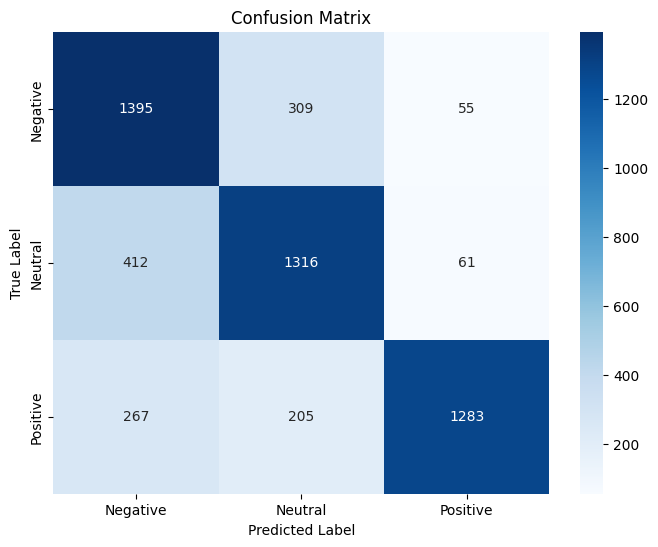

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming test_results is the output from trainer.predict(test_dataset)
y_true = test_results.label_ids
y_pred = np.argmax(test_results.predictions, axis=1)

# Define label names
labels = ["Negative", "Neutral", "Positive"]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with label names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
model.save_pretrained("./finetuned_afriberta_sentiment_model")
tokenizer.save_pretrained("./finetuned_afriberta_sentiment_model")

('./finetuned_afriberta_sentiment_model/tokenizer_config.json',
 './finetuned_afriberta_sentiment_model/special_tokens_map.json',
 './finetuned_afriberta_sentiment_model/sentencepiece.bpe.model',
 './finetuned_afriberta_sentiment_model/added_tokens.json',
 './finetuned_afriberta_sentiment_model/tokenizer.json')

In [ ]:
from transformers import pipeline

# Load model and tokenizer
sentiment_model = AutoModelForSequenceClassification.from_pretrained("./finetuned_afriberta_sentiment_model")
sentiment_tokenizer = AutoTokenizer.from_pretrained("./finetuned_afriberta_sentiment_model")

# Setup a pipeline for sentiment analysis
sentiment_analysis = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=sentiment_tokenizer)

In [ ]:
# Make predictions
text = "abun yamun dadi sosai wallahi"
sentiment = sentiment_analysis(text)
print(sentiment)

[{'label': 'LABEL_2', 'score': 0.9209569096565247}]
